# Assignment #1
John-Craig Borman

3/13/19

QF 302

"I pledge my honor that I have abided by the Stevens Honor System" - John-Craig Borman

## Problem 1

> Collect the bid/ask spread of Netflix's stock price using the SHIFT system with $T = 120$ and $\Delta t = 5$ seconds:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import shift
import time
import pandas as pd
import numpy as np

new_data = False
cache_file = "SHIFT-NFLX.csv"
debug = False

interval_size = 120
num_intervals = 10
wait = 1

df = None

In [2]:
trader = shift.Trader("jborman")
trader.connect("initiator.cfg", "hR7fgSbU")

True

In [3]:
trader.subAllOrderBook()

True

In [4]:
def get_data(ticker, interval=120, wait=5, trader=trader):
    out = pd.DataFrame(columns=["Last Trade", "Last Volume", "Bid", "Ask", "bVolume", "aVolume"])
     
    for i in range(interval):
        if debug: print("loop {}".format(i))
            
        bp = trader.getBestPrice(ticker)
            
        out.loc[i] = [
            trader.getLastPrice(ticker),
            trader.getLastSize(ticker),
            bp.getGlobalBidPrice(), bp.getGlobalAskPrice(),
            bp.getGlobalBidSize(), bp.getGlobalAskSize()
        ]
        
        if i == interval - 1:
            break
        else:
            time.sleep(wait)
            
    return out

In [6]:
if new_data:
    print("Getting new data")
    for i in range(num_intervals):
        tmp = get_data("NFLX", interval=interval_size, wait=wait, trader=trader)
        print("Retrieved interval [{0}/{1}]".format(i+1, num_intervals))

        if df is None:
            df = tmp
        else:
            df = df.append(tmp, ignore_index=False)  

    df.to_csv(cache_filename, index=False)    
else:
    print("Getting cached data")
    df = pd.read_csv(cache_file)
df.head()

Getting cached data


,Last Trade,Last Volume,Bid,Ask,bVolume,aVolume
0,364.59,1.0,364.59,364.99,12.0,9.0
1,364.60,2.0,364.59,364.99,14.0,10.0
2,364.60,2.0,364.61,364.99,6.0,24.0
3,364.64,1.0,364.61,364.98,8.0,1.0
4,364.64,1.0,364.62,364.98,3.0,2.0



### 1.a

**Present a table of summary statistics of $A_t$ and $B_t$**


In [7]:
df[["Bid", "Ask"]].describe()

,Bid,Ask
count,1200.000000,1200.000000
mean,364.382725,364.649883
std,1.446195,1.463646
min,361.550000,361.890000
25%,363.040000,363.280000
50%,364.450000,364.730000
75%,365.880000,366.132500
max,366.800000,367.000000



### 1.b

**Calculate $S^Q$, $S^E$ and $ILLIQ$ for the same data. Plot all three measures in a single graph with two y-axes.**

**Quoted Spread**:

$$ S^Q = \frac{1}{T} \sum_{t=1}^{T}(A_t - B_t) $$

**Average Spread**:

$$ S^E = \frac{1}{T} \sum_{t=1}^{T} 2q_t(P_t - M_t); \quad M_t = \frac{1}{2}(A_t + B_t)$$
    
**Illiquidity**:
    
$$ ILLIQ = \frac{1}{T} \sum_{k=1}^{T} \frac{|r_k|}{V_k} $$

In [8]:
def get_quoted_spread(df):
    """Calculates the quoted spread measure"""
    return (df["Ask"] - df["Bid"]).sum()/df.shape[0]

def get_avg_spread(df):
    """Calculates the average spread measure"""
    
    # Calculate the effective spread
    df["M_t"] = 0.5 * (df["Ask"] + df["Bid"])
    
    # Calculate the direction (1:up, -1:down)
    fltr = df["Last Trade"].diff() >= 0
    df["q"] = -1           
    df.loc[fltr, "q"] = 1
    
    
    return (2 * df["q"] * (df["Last Trade"] - df["M_t"])).sum()/df.shape[0]

def get_illiquidity(df):
    """Calculates the illiquidity measure"""
    
    # Get a directional filter
    fltr = df["Last Trade"].diff() >= 0                 # True -> price increased
    
    # Calculate volume
    df["Volume"] = None
    df.loc[fltr, "Volume"] = df.loc[fltr, "bVolume"]    # When price increases, use bid volume
    df.loc[~fltr, "Volume"] = df.loc[~fltr, "aVolume"]  # When price decreases. use ask volume
    
    # Calculate Return
    df["return"] = df["Last Trade"].pct_change().fillna(0)
    
    return (df["return"].abs() / df["Volume"]).sum() / df.shape[0]
    

In [9]:
get_quoted_spread(df)

0.2671583333333345

In [10]:
get_avg_spread(df)

0.04127499999999609

In [11]:
get_illiquidity(df)

9.82976156150645e-05

In [188]:
df["interval"] = df.reset_index().index.values // interval_size
df.head()

,Last Trade,Last Volume,Bid,Ask,bVolume,aVolume,M_t,q,Volume,return,interval
0,364.59,1.0,364.59,364.99,12.0,9.0,364.790,-1,9,0.000000,0
1,364.60,2.0,364.59,364.99,14.0,10.0,364.790,1,14,0.000027,0
2,364.60,2.0,364.61,364.99,6.0,24.0,364.800,1,6,0.000000,0
3,364.64,1.0,364.61,364.98,8.0,1.0,364.795,1,8,0.000110,0
4,364.64,1.0,364.62,364.98,3.0,2.0,364.800,1,3,0.000000,0


In [17]:
S_Q = df.groupby(["interval"]).apply(get_quoted_spread)
S_E = df.groupby(["interval"]).apply(get_avg_spread)
illiq = df.groupby(["interval"]).apply(get_illiquidity)

calcs = pd.DataFrame({
    "sq": S_Q,
    "se": S_E,
    "illiq": illiq
})

calcs

,sq,se,illiq
interval,,,
0,0.280833,0.069167,0.000080
1,0.308083,0.010917,0.000084
2,0.281500,0.087500,0.000077
3,0.253750,0.044583,0.000098
4,0.299833,0.035000,0.000124
5,0.271417,0.034083,0.000110
6,0.240083,0.006583,0.000087
7,0.229417,0.011083,0.000091
8,0.254083,0.058917,0.000122


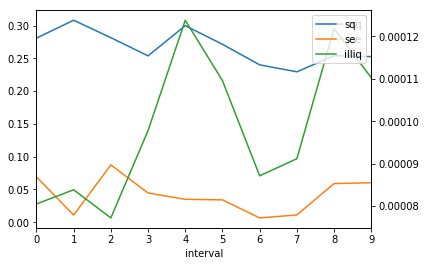

In [23]:
ax1 = calcs[["sq", "se"]].plot()
ax2 = calcs["illiq"].plot(secondary_y=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2, loc = 1)
plt.show()

### 1.c

**Calculate the Pearson correlation between $S^Q$ and $S^E$. Calculate the average Pearson correlation between $S^Q$ and $S^E$**


**Note**: I've calculated the Pearson correlation between these two measures below. I do not quite understand how you expect us to calculate the "_*average*_ Pearson correlation" considering that $S^E$ and $S^Q$ are point in time measures that are calculated at the end of each interval ($T=120$). To properly do so, we would need to calculate $S^E$, $S^Q$ and $ILLIQ$ more than just 10 times over. The correlation between any pair will be a weak estimate given that there are only 10 data points to use. Pulling the data required would take an unreasonable amount of time.

In [29]:
calcs[["sq", "se"]].corr()

,sq,se
sq,1.000000,0.174018
se,0.174018,1.000000


$$\rho (S^Q, S^E) = 0.174$$

### 1.d

**Calculate the Pearson correlation between $S^Q$ and $ILLIQ$. Calculate the average Pearson correlation between $S^Q$ and $S^E$**


**Note**: See my noted comment in the previous question **1.c**

In [31]:
calcs[["sq", "illiq"]].corr()

,sq,illiq
sq,1.000000,-0.040636
illiq,-0.040636,1.000000


$$\rho (S^Q, ILLIQ) = -0.0406$$

### 1.e

**Provide your observations on the relationship between $S^E$ and $S^Q$ as well as $S^Q$ and $ILLIQ$ from the results of 1.c and 1.d**

Naturally, the two measures of spread should approximately move in the same direction. Hence explaining why the two have a weakly positive correlation.

In regards to $S^Q$ and $ILLIQ$, it makes sense that the two would have a negative correlation (albeit a weak one). When spreads tighten, liquitidy increases and therefore illiquidity decreases.

## Problem 2

**Consider the daily stock price data for Netflix as provided from the .CSV file.**

**With realized volatility calculated as:**

$$\sigma_t = \sqrt{\frac{1}{n} \sum_{i=t-n+1}^{t}(r_i-\bar{r})^2}$$

**Using $n=22$ to calculate $\sigma_t$ and $\beta = \frac{2}{n + 1}$** 


In [77]:
nflx = pd.read_csv("NFLX-2013_2018.csv", index_col=0)
nflx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-22,55.405716,55.594284,45.928570,46.074287,46.074287,181099800
2013-10-23,45.331429,47.884285,45.285713,47.177143,47.177143,58376500
2013-10-24,47.348572,48.121429,46.237144,47.317142,47.317142,33559400
2013-10-25,47.285713,48.171429,46.558571,46.861427,46.861427,24062500
2013-10-28,46.430000,47.279999,44.544285,44.857143,44.857143,34260800


In [104]:
def get_rv(px, n=22):
    px = pd.Series(px)
    r = np.log(px) - np.log(px.shift(1)) # Logarithmic return
    r_bar = r.mean()
    
    return (((r - r_bar)**2).sum() / n) ** (0.5)

def get_beta(n=22):
    return 2 / (n + 1)

In [105]:
b = get_beta()

px = nflx["Adj Close"]

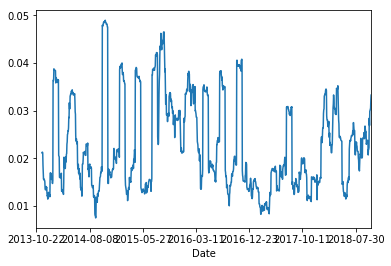

In [107]:
rv = px.rolling(22, min_periods=22).apply(lambda x: get_rv(x), raw=False)
rv.plot()

### 2.a

**Forecast volatility using the Random Walk method: $\hat{\sigma}_t = \sigma_{t-1}$**

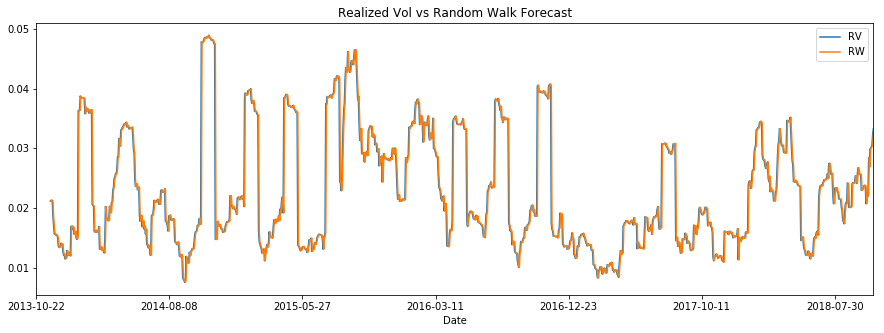

In [129]:
vol_1 = rv.shift(1)

plot_df = pd.concat([rv, vol_1], axis=1)
plot_df.columns = ["RV", "RW"]
plot_df.plot(figsize=(15, 5), title="Realized Vol vs Random Walk Forecast")

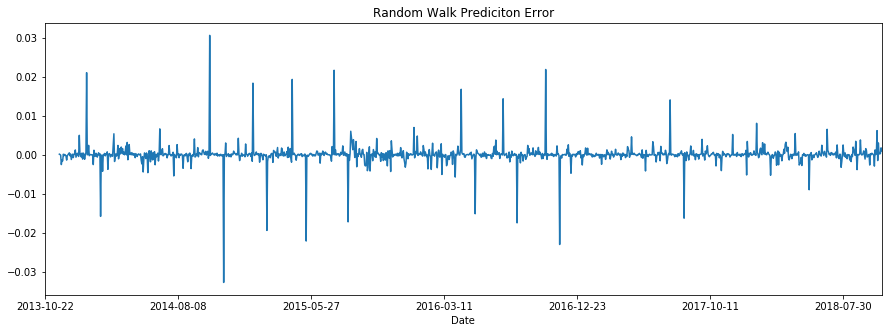

In [165]:
vol_1_err = rv - vol_1
vol_1_err.plot(figsize=(15, 5), title="Random Walk Prediciton Error")

### 2.b

**Forecast using the *exponential smoothing average* (EMA):**

**$$\hat{\sigma}_t = (1-\beta)\sigma_{t-1} + \beta \hat{\sigma}_{t-1}, 0 < \beta < 1$$**

In [166]:
vol_2_sma = rv.rolling(window=22, min_periods=22).mean()
vol_2 = vol_2_sma.ewm(span=22, adjust=False).mean()

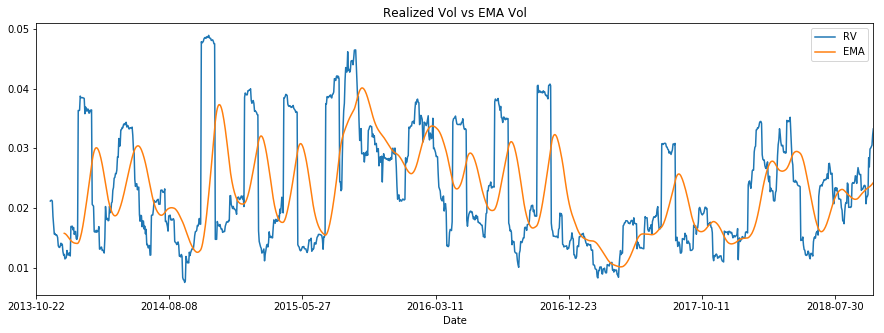

In [167]:
plot_df = pd.concat([rv, vol_2], axis=1)
plot_df.columns = ["RV", "EMA"]

plot_df.plot(figsize=(15, 5), title = "Realized Vol vs EMA Vol")

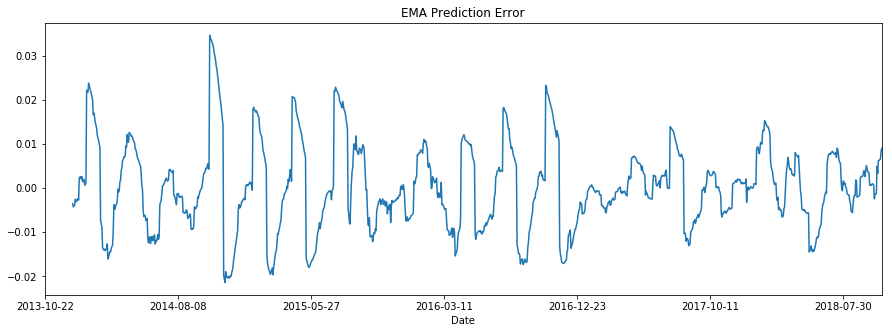

In [168]:
vol_2_err = rv - vol_2
vol_2_err.plot(figsize=(15, 5), title = "EMA Prediction Error")

### 2.c

**Forecast using the *exponentially weighted moving average* (EWMA):**

**$$\hat{\sigma}_t = \frac{\sum_{i=1}^{n}\beta^i\sigma_{t-i} } {\sum_{i=1}^{n}\beta^i}, \quad 0 < \beta < 1 $$**

In [169]:
vol_3 = rv.ewm(span=22, min_periods=22).mean()

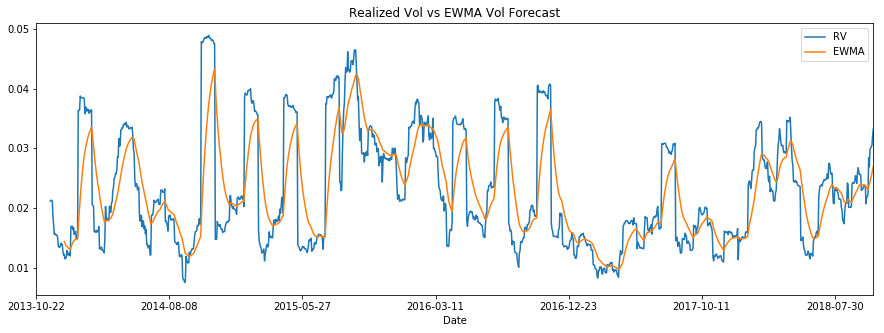

In [170]:
plot_df = pd.concat([rv, vol_3], axis=1)
plot_df.columns = ["RV", "EWMA"]

plot_df.plot(figsize=(15, 5), title = "Realized Vol vs EWMA Vol Forecast")

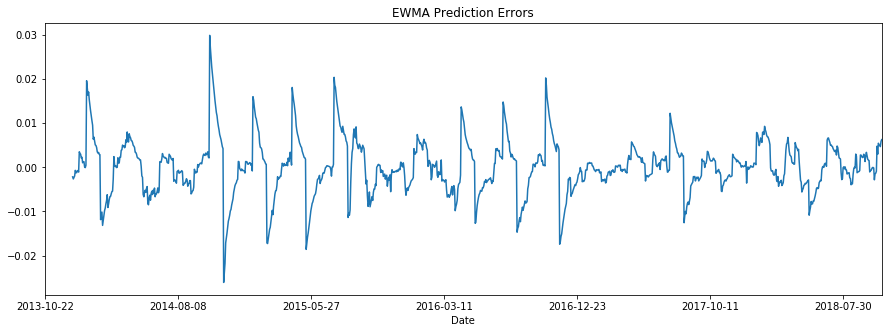

In [171]:
vol_3_err = rv - vol_3
vol_3_err.plot(figsize=(15, 5), title="EWMA Prediction Errors")

### 2.d

**Compare and contrast the differences of the 3 estimation methods**

In [173]:
errs = pd.DataFrame({
    "RW": vol_1_err,
    "EMA": vol_2_err,
    "EWMA": vol_3_err
})

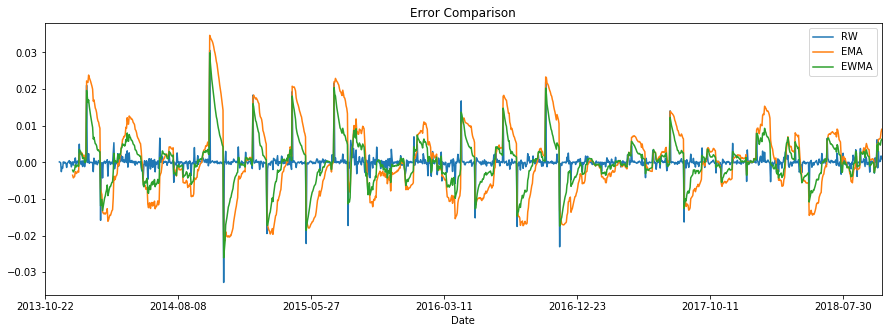

In [174]:
errs.plot(figsize=(15, 5), title="Error Comparison")

The plot above showcases the erros over time in each forecasting model. The Random Walk (RW) method is largely representative of a white noise series with large spikes every so often. The EMA method has consistent, wide wavey deviations from the actual value while the EWMA is much tighter.

In [176]:
errs.mean(axis=0)

RW      0.000010
EMA     0.000185
EWMA    0.000106
dtype: float64

The average errors of each forecasting method are shown above. The Random Walk has the lowest error while the EMA has the highest with the EWMA laying in the middle.

In [177]:
errs.var(axis=0)

RW      0.000008
EMA     0.000095
EWMA    0.000037
dtype: float64

Similarly, we can see analogous results above in the variance of each series of errors. RW, EWMA and EMA with the lowest, middle and highest variability in errors.

The fact that the RW method works so well can likely be attributed to the fact that volatility exists in regimes. If volatility is high in one moment, it is likely to be high in the next. But, when the volatility drops, we see excessively large spikes in errors even with the random walk model. The EMA and EWMA attempt to track these "momentum" features, however the EWMA is the most consistent at doing so with lower, more consistent error variability.

## Problem 3

### 3.a

**Variance:**

$$\gamma_0 \equiv Var(\Delta p_t) = 2c^2 + \sigma^2_u$$

**Autocovariance:**

$$\gamma_1 \equiv Cov(\Delta p_{t-1}, \Delta p_t) = -c^2$$

**Please derive the value $\gamma_l, l \ge 2$**

                    Note: See attached...
                    
                    
### 3.b

**Use the Roll model to estimate the bid-ask spread and fundamental volatility of NFLX**

$\Delta p_t$ may be calculated emprically using the difference in Adjusted Close prices. With that, we may determine the autocovariance: $\gamma_1 \equiv Cov(\Delta p_{t-1}, \Delta p_t)$ and thus the bid ask spread as:

$$c = -\sqrt{\gamma_1}$$

Additionally, the fundamental volatility may be inferred by:

$$\sigma^2_u = \gamma_0 - 2c^2$$

In [179]:
m = nflx["Adj Close"].diff()
gamma_1 = m.cov(m.shift(1))
gamma_0 = m.var()

In [181]:
m.head()

Date
2013-10-22         NaN
2013-10-23    1.102856
2013-10-24    0.139999
2013-10-25   -0.455715
2013-10-28   -2.004284
Name: Adj Close, dtype: float64

In [182]:
gamma_1

0.3388176029651567

In [183]:
gamma_0

17.942982174550465

In [185]:
c = - (gamma_1 ** 0.5)
spread = 2 * c
spread

-1.1641608187276475

In [186]:
vol_f = gamma_0 - (2 * c **2)
vol_f

17.26534696862015

According to the analysis above, the spread $2c = -1.164$ and the fundamental volatility $\sigma^2_u = 17.265$